<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

last updated: 2017-10-11 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.7.0


# Energy reconstruction
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Weight simulation events to spectrum](#Weight-simulation-events-to-spectrum)
3. [S125 verification](#S125-verification)
4. [$\log_{10}(\mathrm{dE/dX})$ verification](#$\log_{10}(\mathrm{dE/dX})$-verification)

In [2]:
from __future__ import division, print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import seaborn.apionly as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.externals import joblib

import comptools as comp
import comptools.analysis.plotting as plotting

color_dict = comp.analysis.get_color_dict()

%matplotlib inline

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Welcome to JupyROOT 6.09/02


# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature selection

### Load simulation, format feature and target matrices

In [3]:
# feature_list = ['lap_cos_zenith', 'log_s125']
# feature_list = ['log_s80', 'log_s125', 'log_s250', 'lap_cos_zenith',
#                 'FractionContainment_Laputop_IceTop', 'NStations']

# feature_list = ['log_s50', 'log_s125', 'log_s250', 'lap_cos_zenith', 'NStations', 'FractionContainment_Laputop_IceTop',
#                 'log_dEdX']
# feature_labels = ['$\mathrm{\log_{10}(S_{50})}$', '$\mathrm{\log_{10}(S_{125})}$', '$\mathrm{\log_{10}(S_{250})}$', 
#                   '$\mathrm{\cos(\\theta)}$', 'NStations', 'IT Conainment', '$\mathrm{\log_{10}(dE/dX)}$']

feature_list, feature_labels = comp.get_training_features()
feature_list

['lap_cos_zenith', 'log_s125', 'log_dEdX']

In [4]:
# df_sim_train, df_sim_test = comp.load_sim(config='IC79.2010')
df_sim_train, df_sim_test = comp.load_sim(config='IC86.2012')

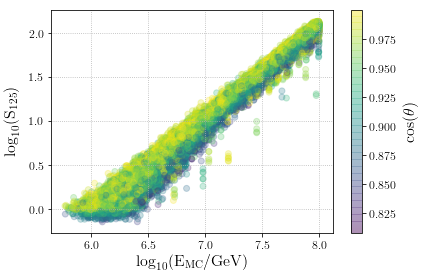

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [5]:
fig, ax = plt.subplots()
sc = ax.scatter(df_sim_train['MC_log_energy'], df_sim_train['log_s125'],
                c=df_sim_train['lap_cos_zenith'], alpha=0.25)
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
plt.colorbar(sc, label='$\mathrm{\cos(\\theta)}$')
s125_vs_MC_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         's125_vs_MC_energy_zenith.png')
comp.check_output_dir(s125_vs_MC_energy_outfile)
plt.savefig(s125_vs_MC_energy_outfile)
plt.show()

In [7]:
comp_list = comp.get_comp_list(num_groups=2)
comp_list

['heavy', 'light']

In [9]:
comp_mask_train, comp_mask_test = {}, {}
for composition in comp_list:
    comp_mask_train[composition] = df_sim_train['MC_comp_class'] == composition
    comp_mask_test[composition] = df_sim_test['MC_comp_class'] == composition

In [10]:
energybins = comp.analysis.get_energybins()

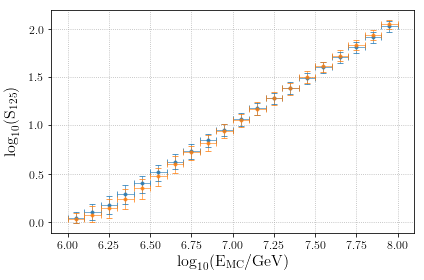

In [11]:
fig, ax = plt.subplots()
for composition in comp_list:
    log_s125 = df_sim_train.loc[comp_mask_train[composition], 'log_s125']
    MC_log_energy = df_sim_train.loc[comp_mask_train[composition], 'MC_log_energy']

    _, bin_medians, error = comp.analysis.get_medians(MC_log_energy, log_s125,
                                                      energybins.log_energy_bins)
    ax.errorbar(energybins.log_energy_midpoints, bin_medians, yerr=error, xerr=0.05, 
                marker='.', ls='None', label='light', color=color_dict[composition], alpha=0.75)
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
plt.show()

In [124]:
h, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], df_sim_test['log_dEdX'],
                                    bins=[np.linspace(6.0, 8.0, 100), np.linspace(-0.5, 3, 100)])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
h = np.rot90(h)
h = np.flipud(h)

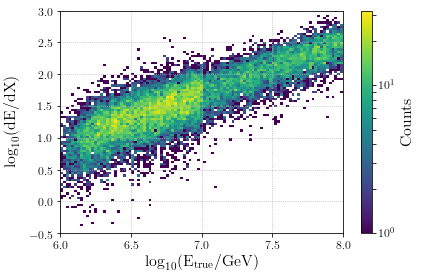

In [125]:
fig, ax = plt.subplots()
plt.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none', aspect='auto')
# ax.set_xlim([6.4, 8.0])
# ax.set_ylim([6.4, 8.0])
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(dE/dX)}$')
ax.grid()
plt.colorbar(label='Counts')
# true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
#                                          'MC_vs_reco_energy.png')
# comp.check_output_dir(true_vs_reco_energy_outfile)
# plt.savefig(true_vs_reco_energy_outfile)
plt.show()

Define scoring function

In [74]:
def median_energy_res(log_energy, log_energy_pred):
    return np.median(log_energy-log_energy_pred)
scorer = make_scorer(median_energy_res, greater_is_better=False)

In [75]:
parameters = {'max_depth': np.arange(1, 11), 'n_estimators': np.arange(1, 100, 10)}
gs = GridSearchCV(RandomForestRegressor(random_state=2, verbose=1), parameters, scoring='neg_mean_squared_error',
                  cv=10, n_jobs=10, verbose=2)

# parameters = {'C': np.linspace(0.01, 1, 10)}
# gs = GridSearchCV(SVR(), parameters, cv=10, n_jobs=10, verbose=2)

In [76]:
gs.fit(df_sim_train[feature_list], df_sim_train['MC_log_energy'])
gs.best_params_

{'max_depth': 10, 'n_estimators': 91}

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] n_estimators=1, max_depth=1 .....................................
[CV] ...................... n_estimators=1, max_depth=1, total=   0.0s
[CV] n_estimators=11, max_depth=1 ....................................
[CV] ..................... n_estimators=11, max_depth=1, total=   0.3s
[CV] n_estimators=21, max_depth=1 ....................................
[CV] ..................... n_estimators=21, max_depth=1, total=   0.5s
[CV] n_estimators=21, max_depth=1 ....................................
[CV] ..................... n_estimators=21, max_depth=1, total=   0.3s
[CV] n_estimators=21, max_depth=1 ....................................
[CV] ..................... n_estimators=21, max_depth=1, total=   0.3s
[CV] n_estimators=21, max_depth=1 ....................................
[CV] ..................... n_estimators=21, max_depth=1, total=   0.4s
[CV] n_estimators=61, max_depth=1 ....................................
[CV] .......

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

In [77]:
# cv_results = pd.DataFrame(gs.cv_results_)

In [78]:
clf = gs.best_estimator_
# clf = RandomForestRegressor(max_depth=10, n_estimators=91, random_state=2, n_jobs=10, verbose=1)

In [79]:
# clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=2)
# clf = RandomForestRegressor(n_estimators=100, n_jobs=10, random_state=2)

In [80]:
clf.fit(df_sim_train[feature_list], df_sim_train['MC_log_energy'])
reco_log_energy = clf.predict(df_sim_test[feature_list])

[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:    0.2s finished


In [126]:
reco_log_energy

array([ 6.08980593,  7.47555937,  7.38462919, ...,  6.77072477,
        6.40434004,  6.17433091])

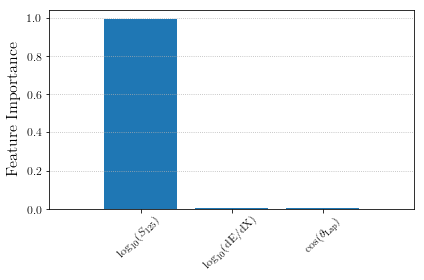

1) 0.991778021917
2) 0.0046679790327
3) 0.00355399904992


In [127]:
num_features = len(feature_list)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

ax.set_ylabel('Feature Importance')
ax.bar(range(num_features), importances[indices], align='center')
plt.xticks(range(num_features), np.array(feature_labels)[indices], rotation=45)
ax.set_xlim([-1, len(feature_list)])
ax.grid(axis='y')
plt.show()

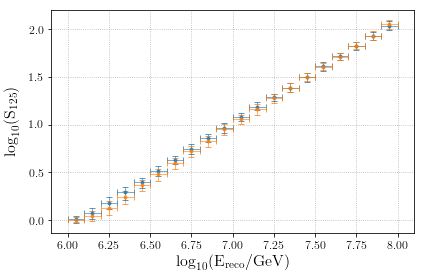

In [128]:
fig, ax = plt.subplots()
for composition in comp_list:
    log_s125 = df_sim_test.loc[comp_mask_test[composition], 'log_s125']
    log_energy = reco_log_energy[comp_mask_test[composition]]

    _, bin_medians, error = comp.analysis.get_medians(log_energy, log_s125,
                                                      energybins.log_energy_bins)
    ax.errorbar(energybins.log_energy_midpoints, bin_medians, yerr=error, xerr=0.05, 
                marker='.', ls='None', label='light', color=color_dict[composition], alpha=0.75)
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
plt.show()

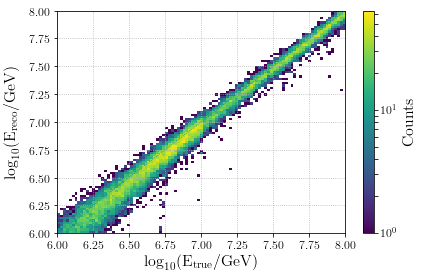

In [136]:
h, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], df_sim_test['lap_log_energy'],
                                    bins=np.linspace(6.0, 8.0, 100))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
h = np.rot90(h)
h = np.flipud(h)

fig, ax = plt.subplots()
plt.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none', aspect='auto')
ax.plot([6, 8], [6, 8], marker='None', ls=':')
# ax.set_xlim([6.4, 8.0])
# ax.set_ylim([6.4, 8.0])
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.grid()
plt.colorbar(label='Counts')
true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         'MC_vs_lap_energy.png')
comp.check_output_dir(true_vs_reco_energy_outfile)
plt.savefig(true_vs_reco_energy_outfile)
plt.show()

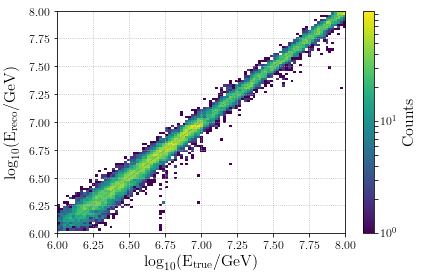

In [137]:
h, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], reco_log_energy,
                                    bins=np.linspace(6.0, 8.0, 100))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
h = np.rot90(h)
h = np.flipud(h)

fig, ax = plt.subplots()
plt.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none', aspect='auto')
ax.plot([6, 8], [6, 8], marker='None', ls=':')
# ax.set_xlim([6.4, 8.0])
# ax.set_ylim([6.4, 8.0])
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.grid()
plt.colorbar(label='Counts')
true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         'MC_vs_reco_energy.png')
comp.check_output_dir(true_vs_reco_energy_outfile)
plt.savefig(true_vs_reco_energy_outfile)
plt.show()

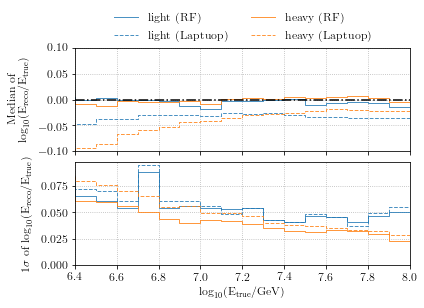

In [86]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

for composition in comp_list:
    comp_mask = df_sim_test['MC_comp_class'] == composition
    
    # Plot RF reco energy 
    medians, stds, _ = comp.analysis.get_median_std(
            df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'], energy_res[comp_mask_test[composition]],
            energybins.log_energy_bins)

    plotting.plot_steps(energybins.log_energy_bins, medians, lw=1,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax1)

    plotting.plot_steps(energybins.log_energy_bins, stds, lw=1,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax2)
    
    # Plot Laputop reco energy 
    medians, stds, _ = comp.analysis.get_median_std(
            df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'], lap_energy_res[comp_mask_test[composition]],
            energybins.log_energy_bins)

    plotting.plot_steps(energybins.log_energy_bins, medians, lw=1, ls='--',
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (Laptuop)', ax=ax1)

    plotting.plot_steps(energybins.log_energy_bins, stds, lw=1, ls='--',
                        color=color_dict[composition], alpha=0.8, 
                        label=composition+' (Laptuop)', ax=ax2)

ax1.axhline(0, marker='None', linestyle='-.', color='k', lw=1.5)
ax1.set_ylabel('Median of\n$\mathrm{\log_{10}(E_{reco}/E_{true})}$', fontsize=12)
ax1.set_ylim(-0.1, 0.1)
ax1.tick_params(labelbottom='off')
ax1.grid()
# ax1.legend(title='True composition')
leg = ax1.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
                                 1.45),# vertical 
                 ncol=len(comp_list), fancybox=False, fontsize=12)

ax2.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$', fontsize=12)
ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$', fontsize=12)
ax2.set_ylim(0)
ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax2.grid()

ax2.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res.png')
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

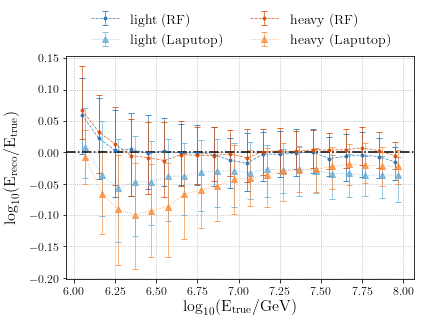

In [87]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']


fig, ax = plt.subplots()
res_color_dict = {'light': sns.color_palette('Blues', 3).as_hex()[::-1],
                  'heavy': sns.color_palette('Oranges', 3).as_hex()[::-1]}
for composition in comp_list:
    comp_mask = df_sim_test['MC_comp_class'] == composition
    
    bin_centers, bin_medians, error = comp.analysis.get_medians(
                            df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'], 
                            energy_res[comp_mask_test[composition]],
                            energybins.log_energy_bins)
    ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', ls='--', 
                color=res_color_dict[composition][0], alpha=0.8, label=composition + ' (RF)')

    
    bin_centers, bin_medians, error = comp.analysis.get_medians(
                            df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'], 
                            lap_energy_res[comp_mask_test[composition]],
                            energybins.log_energy_bins)
    ax.errorbar(bin_centers + 0.02, bin_medians, yerr=error, marker='^', ls=':', 
                color=res_color_dict[composition][1], alpha=0.8, label=composition + ' (Laputop)')
    
ax.axhline(0, marker='None', linestyle='-.', color='k', lw=1.5)
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
# ax.set_ylim(-0.1, 0.1)
ax.grid()
# ax.legend()
leg = ax.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
                                 1.25),# vertical 
                 ncol=len(comp_list), fancybox=False)

# ax2.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
# ax2.set_ylim(0)
# ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
# ax2.grid()

# ax.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res_comparison.png')
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

In [28]:
def plot_validation_curve(validation_dict, param_name, ylime=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    ax.plot(validation_dict['range'], validation_dict['train_mean'], label="Training score",
             color='C0')
    ax.fill_between(validation_dict['range'], validation_dict['train_mean'] - validation_dict['train_std'],
                     validation_dict['train_mean'] + validation_dict['train_std'], alpha=0.2,
                     color='C0')
    
    ax.plot(validation_dict['range'], validation_dict['test_mean'], label="Cross-validation score",
                 color='C2')
    ax.fill_between(validation_dict['range'], validation_dict['test_mean'] - validation_dict['test_std'],
                     validation_dict['test_mean'] + validation_dict['test_std'], alpha=0.2,
                     color='C2')
    
    ax.set_xlabel(param_name)
    ax.set_ylabel('Median energy resolution')
    ax.grid()
    ax.legend()
    
    return ax

## Validation curve for maximum tree depth

In [12]:
max_depth_validation = {}
max_depth_validation['range'] = np.arange(1, 11)
train_scores, test_scores = validation_curve(clf, sim_train.X, sim_train.y,
                                param_name='max_depth', param_range=max_depth_validation['range'],
                                cv=10, scoring=scorer, n_jobs=5, verbose=2)
max_depth_validation['train_mean'] = np.mean(train_scores, axis=1)
max_depth_validation['train_std'] = np.std(train_scores, axis=1)
max_depth_validation['test_mean'] = np.mean(test_scores, axis=1)
max_depth_validation['test_std'] = np.std(test_scores, axis=1)

[CV] max_depth=1 .....................................................
[CV] max_depth=2 .....................................................
[CV] max_depth=3 .....................................................
[CV] max_depth=4 .....................................................
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=1, total=   1.3s
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=2, total=   2.1s
[CV] max_depth=7 .....................................................
[CV] ...................................... max_depth=3, total=   3.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=4, total=   3.7s
[CV] max_depth=9 .....................................................
[CV] ...................................... max_depth=5, total=   4.1s
[CV] m

[Parallel(n_jobs=5)]: Done  50 out of 100 | elapsed:   50.1s remaining:   50.1s


[CV] ...................................... max_depth=9, total=   7.4s
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=3, total=   2.8s
[CV] max_depth=7 .....................................................
[CV] ..................................... max_depth=10, total=   7.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=4, total=   3.4s
[CV] max_depth=9 .....................................................
[CV] ...................................... max_depth=5, total=   4.1s
[CV] max_depth=10 ....................................................
[CV] ...................................... max_depth=6, total=   4.7s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=7, total=   6.0s
[CV] max_depth=2 .....................................................
[CV] .

[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.7min finished


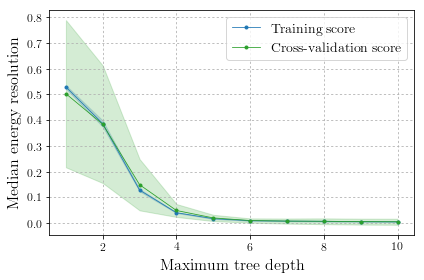

In [22]:
fig, ax = plt.subplots()
ax = plot_validation_curve(max_depth_validation, 'Maximum tree depth', ax=ax)
plt.show()

In [14]:
max_depth_validation

{'range': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'test_mean': array([ 0.50255475,  0.3839728 ,  0.14932636,  0.04934139,  0.02041614,
         0.0103807 ,  0.00827866,  0.00750279,  0.00609946,  0.00564338]),
 'test_std': array([ 0.2856297 ,  0.22810723,  0.09949119,  0.0250328 ,  0.01215241,
         0.0083085 ,  0.00996272,  0.01126581,  0.01158005,  0.01175209]),
 'train_mean': array([ 0.52882301,  0.38635185,  0.12845208,  0.04070192,  0.01760879,
         0.00977809,  0.00807251,  0.00724977,  0.00594708,  0.00528878]),
 'train_std': array([ 0.00635995,  0.01219002,  0.00465081,  0.00136199,  0.00076338,
         0.00056396,  0.00047198,  0.00055677,  0.00057028,  0.00056188])}

In [30]:
clf.set_params(max_depth=20)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=5, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

In [18]:
n_estimators_validation = {}
n_estimators_validation['range'] = np.arange(10, 500, 100)
train_scores, test_scores = validation_curve(clf, sim_train.X, sim_train.y,
                                param_name='n_estimators', param_range=n_estimators_validation['range'],
                                cv=10, scoring=scorer, n_jobs=5, verbose=2)
n_estimators_validation['train_mean'] = np.mean(train_scores, axis=1)
n_estimators_validation['train_std'] = np.std(train_scores, axis=1)
n_estimators_validation['test_mean'] = np.mean(test_scores, axis=1)
n_estimators_validation['test_std'] = np.std(test_scores, axis=1)

[CV] n_estimators=10 .................................................
[CV] n_estimators=110 ................................................
[CV] n_estimators=210 ................................................
[CV] n_estimators=310 ................................................
[CV] n_estimators=410 ................................................
[CV] .................................. n_estimators=10, total=   1.4s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.8s
[CV] n_estimators=110 ................................................
[CV] ................................. n_estimators=110, total=  15.5s
[CV] n_estimators=210 ................................................
[CV] ................................. n_estimators=110, total=  16.1s
[CV] n_estimators=310 ................................................
[CV] ................................. n_estimators=210, total=  29.1s
[CV] n

[Parallel(n_jobs=5)]: Done  25 out of  50 | elapsed:  2.9min remaining:  2.9min


[CV] ................................. n_estimators=210, total=  29.5s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   3.3s
[CV] n_estimators=110 ................................................
[CV] ................................. n_estimators=310, total=  46.0s
[CV] n_estimators=210 ................................................
[CV] ................................. n_estimators=110, total=  15.5s
[CV] n_estimators=310 ................................................
[CV] ................................. n_estimators=310, total=  44.0s
[CV] n_estimators=410 ................................................
[CV] ................................. n_estimators=410, total= 1.0min
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.5s
[CV] n_estimators=110 ................................................
[CV] .

[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  5.9min finished


In [19]:
n_estimators_validation

{'range': array([ 10, 110, 210, 310, 410]),
 'test_mean': array([ 0.00548868,  0.00557944,  0.00558756,  0.00561756,  0.00561365]),
 'test_std': array([ 0.01186723,  0.01175808,  0.01175578,  0.01177776,  0.01176778]),
 'train_mean': array([ 0.00516754,  0.00529662,  0.00528581,  0.00528698,  0.00528427]),
 'train_std': array([ 0.00056915,  0.00057155,  0.00057321,  0.00056888,  0.00056973])}

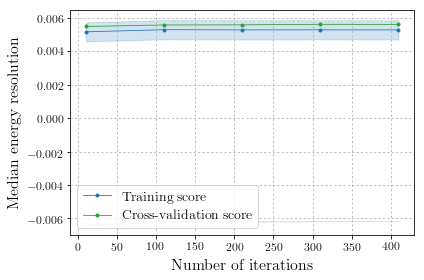

In [20]:
fig, ax = plt.subplots()
ax = plot_validation_curve(n_estimators_validation, 'Number of iterations', ax=ax)
plt.show()

In [36]:
clf.set_params(n_estimators=200)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=5, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

In [37]:
clf = clf.fit(sim_train.X, sim_train.y)
train_pred = clf.predict(sim_train.X)
# train_acc = mean_squared_error(sim_train.y, train_pred)
train_score = median_energy_res(sim_train.y, train_pred)

test_pred = clf.predict(sim_test.X)
# test_acc = mean_squared_error(sim_test.y, test_pred)
test_score = median_energy_res(sim_test.y, test_pred)
print('Testing score: {}'.format(test_score))
print('Training score: {}'.format(train_score))

Testing score: -0.00309242751178
Training score: -0.00238709415859


In [38]:
energy_bins = 10**np.arange(5.0, 9.51, 0.1)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2

In [39]:
light_mask = sim_test.comp == 'light'
heavy_mask = sim_test.comp == 'heavy'

In [40]:
energy_resolution = np.log10(test_pred/sim_test.y)
_, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(np.log10(sim_test.y)[light_mask],
                                                                           energy_resolution[light_mask],
                                                                           np.log10(energy_bins))
_, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(np.log10(sim_test.y)[heavy_mask],
                                                                           energy_resolution[heavy_mask],
                                                                           np.log10(energy_bins))

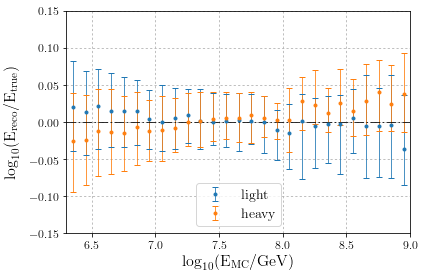

In [41]:
fig, ax = plt.subplots()
ax.errorbar(np.log10(energy_midpoints), bin_medians_light, yerr=error_light,
            marker='.', ls='None', label='light')
ax.errorbar(np.log10(energy_midpoints), bin_medians_heavy, yerr=error_heavy,
            marker='.', ls='None', label='heavy')
ax.axhline(0, marker='None', linestyle='-.', color='k')
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.set_xlim([6.3, 9.0])
ax.set_ylim([-0.15, 0.15])
ax.legend()
plt.grid()
# plt.savefig('/home/jbourbeau/public_html/figures/lap-energyres.png')
plt.show()

In [43]:
joblib.dump(clf, 'regressor.pkl') 

['regressor.pkl']